# This notebook is to adjust and save files that are worked with

Packages

In [2]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [3]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)[var].data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values-273.15 # dew point temperature in celsius

    # Extract air temperature (T) values from the input dataset, and convert to celsius
    T = era5_ds.t2m.values # temperature in celsius
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

SD variable names

In [4]:
dat = ['WIND_FROM_MEAN',
           'WIND_FROM_STDDEV', 
           'WIND_SPEED_MEAN',
           'WIND_SPEED_STDDEV',
           'UWND_MEAN',
           'UWND_STDDEV',
           'VWND_MEAN',
           'VWND_STDDEV',
           'WWND_MEAN',
           'WWND_STDDEV',
           'GUST_WND_MEAN',
           'GUST_WND_STDDEV',
           'WIND_MEASUREMENT_HEIGHT_MEAN',
           'WIND_MEASUREMENT_HEIGHT_STDDEV',
           'TEMP_AIR_MEAN',
           'TEMP_AIR_STDDEV',
           'RH_MEAN',
           'RH_STDDEV',
           'BARO_PRES_MEAN',
           'BARO_PRES_STDDEV',
           'PAR_AIR_MEAN',
           'PAR_AIR_STDDEV',
           'LW_IRRAD_MEAN',
           'LW_IRRAD_STDDEV',
           'SW_IRRAD_TOTAL_MEAN',
           'SW_IRRAD_TOTAL_STDDEV',
           'SW_IRRAD_DIFFUSE_MEAN',
           'SW_IRRAD_DIFFUSE_STDDEV',
           'TEMP_IR_SEA_WING_UNCOMP_MEAN',
           'TEMP_IR_SEA_WING_UNCOMP_STDDEV',
           'WAVE_DOMINANT_PERIOD',
           'WAVE_SIGNIFICANT_HEIGHT',
           'TEMP_DEPTH_HALFMETER_MEAN',
           'TEMP_DEPTH_HALFMETER_STDDEV',
           'TEMP_SBE37_MEAN',
           'TEMP_SBE37_STDDEV',
           'SAL_SBE37_MEAN',
           'SAL_SBE37_STDDEV',
           'COND_SBE37_MEAN',
           'COND_SBE37_STDDEV',
           'O2_CONC_SBE37_MEAN',
           'O2_CONC_SBE37_STDDEV',
           'O2_SAT_SBE37_MEAN',
           'O2_SAT_SBE37_STDDEV',
           'CHLOR_WETLABS_MEAN',
           'CHLOR_WETLABS_STDDEV',
           'XCO2_DRY_SW_MEAN_ASVCO2',
           'XCO2_DRY_AIR_MEAN_ASVCO2'
          ]

## Paths to files

SD

In [6]:
p = pathlib.Path('.').absolute() #absolute path to working directory
pdir = p.parent / 'share/MISSIONS/sochic/saildrone/sd-1067/daily_files/1min/' #add p.parent and the path
#list(pdir.glob('*.nc'))  # lista filel som slutar på .nc i filkatalogen

filename=[]
for file_path in list(pdir.glob('*.nc')): # lista filer som slutar på .nc i filkatalogen
    filename.append(file_path.name)
    #print(file_path.name)
#    print(file_path.stem)
#.   print(file_path)
filename.sort()

files=[]
#path = pdir / filename[0]
for i in range(len(filename)):
    path= pdir / filename[i]
    files.append(xr.open_dataset(path, engine='netcdf4').sel(trajectory=1067).swap_dims({'obs':'time'})[dat])
   # files.append(xr.open_dataset(pdir / filename[i],engine='netcdf4').sel(trajectory=1067).swap_dims({'obs':'time'})[dat]) 
   # ds = xr.concat(tmp,dim='time')

ADCP

In [7]:
p2 = pathlib.Path('.').absolute() #absolute path to working directory
pdir2 = p2.parent / 'share/MISSIONS/sochic/saildrone/sd-1067/daily_files/adcp/' #add p.parent and the path
#list(pdir.glob('*.nc'))  # lista filel som slutar på .nc i filkatalogen

filename2=[]
for file_path2 in list(pdir2.glob('*.nc')): # lista filer som slutar på .nc i filkatalogen
    filename2.append(file_path2.name)
    #print(file_path.name)
#    print(file_path.stem)
#.   print(file_path)
filename2.sort()

files2=[]
#path = pdir / filename[0]
for i in range(len(filename2)):
    path2= pdir2 / filename2[i]
    files2.append(xr.open_dataset(path2, engine='netcdf4').sel(trajectory=1067).swap_dims({'obs':'time'}))
   # files.append(xr.open_dataset(pdir / filename[i],engine='netcdf4').sel(trajectory=1067).swap_dims({'obs':'time'})[dat]) 
   # ds = xr.concat(tmp,dim='time')

OSTIA

In [8]:
p3 = pathlib.Path('.').absolute() #absolute path to working directory
pdir3 = p3.parent/'MTmichaela/MasterH23/OSTIA/' #add p.parent and the path
#list(pdir.glob('*.nc'))  # lista filel som slutar på .nc i filkatalogen

filename=[]
for file_path in list(pdir3.glob('*.nc')): # lista filer som slutar på .nc i filkatalogen
    filename.append(file_path.name)

filename.sort()

files3=[]
#path = pdir / filename[0]
for i in range(len(filename)):
    path= pdir3 / filename[i]
    files3.append(xr.open_dataset(path, engine='netcdf4'))#.sel(trajectory=1067).swap_dims({'obs':'time'})[dat])
   

Create and save ds & ERA5

In [10]:
ds = xr.concat(files,dim='time') #Gör om till ett xarray dataset'
#wind10=[]
#windu10=[]
#windv10=[]
#for i in np.arange(len(ds.WIND_MEASUREMENT_HEIGHT_MEAN)):
#    wind10.append(wind_sp_to_10m(ds.WIND_SPEED_MEAN[i], z0=1.52e-4, zm=ds.WIND_MEASUREMENT_HEIGHT_MEAN[i], z10=10))#Refer windmeasurement from SD measured height to 10 m
#    windu10.append(wind_sp_to_10m(ds.UWND_MEAN[i], z0=1.52e-4, zm=ds.WIND_MEASUREMENT_HEIGHT_MEAN[i], z10=10))
#    windv10.append(wind_sp_to_10m(ds.VWND_MEAN[i], z0=1.52e-4, zm=ds.WIND_MEASUREMENT_HEIGHT_MEAN[i], z10=10))
    
    #    wind2.append(wind_sp_to_10m(ds.WIND_SPEED_MEAN[i], z0=1.52e-4, zm=ds.WIND_MEASUREMENT_HEIGHT_MEAN[i], z10=2))

ds['u10']=ds.UWND_MEAN #=xr.concat(windu10, dim='time')
ds['v10']=ds.VWND_MEAN #OBS!!!!!!!!!! ds.u10 and v10 is NOT corrected to 10 m, change of methods will correct wind in ASFC. Assigning them to this variable is ONLY to make it easier in colocating to ERA5 data, which is the data used!!!!!

ds['SAL_ABS']=(gsw.SA_from_SP(ds.SAL_SBE37_MEAN,0, ds.longitude, ds.latitude) )
ds['TEMP_CONS']=gsw.CT_from_t(ds.SAL_ABS, ds.TEMP_SBE37_MEAN,0)
ds['DENS']=gsw.rho(ds.SAL_ABS, ds.TEMP_CONS, 0)
#ds['WIND_CORR2']=xr.concat(wind2, dim='time')


ds=ds.rename({'BARO_PRES_MEAN':'P_SEA'})
ds=ds.rename({'LW_IRRAD_MEAN':'dwlw'})
ds=ds.rename({'SW_IRRAD_TOTAL_MEAN':'dwsw'})
ds=ds.rename({'TEMP_SBE37_MEAN':'sst'})
ds=ds.rename({'TEMP_AIR_MEAN':'t2m'}) #rename to same names as ERA5 for coloc function
ds=ds.rename({'RH_MEAN':'rh'})

ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5.nc')

ERA5['P_SEA']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5p.nc').msl
ERA5['v10']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5v10.nc').v10
ERA5['sst']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5sst.nc').sst-273.15

ERA5['d2m']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5d2m.nc').d2m
ERA5['t2m']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5t2m.nc').t2m-273.15
ERA5['dwlw']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5lwsw.nc').msdwlwrf
ERA5['dwsw']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5lwsw.nc').msdwswrf
ERA5['dwlwc']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5lwsw.nc').msdwlwrfcs
ERA5['dwswc']=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5lwsw.nc').msdwswrfcs
ERA5['WIND_CORR10']=(ERA5.u10**2+ERA5.v10**2)**0.5
ERA5['P_SEA']=ERA5['P_SEA']/100
ERA5=era5dewtorh(ERA5)

In [11]:
#Save datasets as files
ds.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5file.nc') 


Create dsadcpH

In [38]:
ds=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5file.nc')

dsH=ds.reset_coords().resample(time='1H').mean().set_coords(['latitude','longitude']) #resampla datasetet till 1H res.
dsD=ds.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping

adcp=xr.concat(files2,dim='time')
gebco=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/gebcoCT.nc') #ladda bathymetry
adcpsur=adcp.sel(cell_depth=4.2) #Surface current-data


adcpsur=adcpsur.rename({'vel_east':'u10'})
adcpsur=adcpsur.rename({'vel_north':'v10'})

adcpsurH=adcpsur.sortby('time').reset_coords().resample(time='1H').mean().set_coords(['latitude','longitude'])
dsadcpH=dsH.sel(time=adcpsurH.time, method='nearest')

dsadcpH['cur_u']=(adcpsurH.u10.values)
dsadcpH['cur_v']=(adcpsurH.v10.values)

dsadcpH['cur_u']=dsadcpH['cur_u'].swap_dims({"cur_u": "time"})
dsadcpH['cur_v']=dsadcpH['cur_v'].swap_dims({"cur_v": "time"})
dsadcpH['abs_cur']=(dsadcpH.cur_u**2+dsadcpH.cur_v**2)**0.5 #Create absolute speed for surface currents, but!!! To calculate relative windspeeds the u and v vectors needs to be used!!!!!

dsadcpH['WIND_SPEED_MEAN']=dsadcpH['WIND_SPEED_MEAN'].sel(time=np.isfinite(dsadcpH.UWND_MEAN)) #Pick only true values for wind, get rid of the constant "tail" before NaNs
dsadcpH['dist']=dist_era5_sd(dsadcpH ,ERA5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:19<00:00, 85.96it/s]


Reference windspeed to 10 m height w ASFC & create variable

In [39]:
hum1=dsadcpH.rh.values

spd= dsadcpH.WIND_SPEED_MEAN.values #relative windpeed
SST= dsadcpH.sst.values
T= dsadcpH.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= dsadcpH.P_SEA.values #air pressure in hPA
SST_fl ='bulk' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= dsadcpH.latitude.values #latitude
hin=([3.4, 2.3, 2.3])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=dsadcpH.dwlw.values#longwave dwn radiation
Rs= dsadcpH.dwsw.values # shortwave dwn radiation
cskin= 1 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=1 #warm layer off 0 (default)
gust= None # [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= ['uref'] #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)

dsadcpH['WIND_CORR10']= ASFC.uref #xr.concat(wind10, dim='time')
dsadcpH['WIND_CORR10']=dsadcpH['WIND_CORR10'].swap_dims({'dim_0':'time'})
dsadcpH['dist']=dsadcpH['dist'].swap_dims({'dist':'time'})
dsadcpH=dsadcpH.drop(['dim_0'])
dsadcpH=dsadcpH.reset_coords().set_coords(['latitude','longitude'])

Save dsadcpH

In [40]:
dsadcpH.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/dsadcpH.nc') 

Ostia cut off the right area and regrid to hourly times

In [11]:
ostia= xr.concat(files3,dim='time') 
ostia=ostia.rename({'lon':'longitude'})
ostia=ostia.rename({'lat':'latitude'})


In [12]:
start_date= dsadcpH.time.min()
end_date=dsadcpH.time.max()
lon_max= dsadcpH.longitude.max()
lon_min= dsadcpH.longitude.min()

lat_max=dsadcpH.latitude.max()
lat_min=dsadcpH.latitude.min()


cond1= (ostia.latitude>=lat_min) & (ostia.latitude<=lat_max) & (ostia.longitude>=lon_min) & (ostia.longitude<=lon_max) 
ostia=ostia.where(cond1 ,drop=True) 
ostia=ostia.reset_coords().resample(time='1H').pad()
mask = (ostia['time'] >= start_date) & (ostia['time'] <= end_date)# & (ostia['longitude'] >= lon_min) & (ostia['longitude']<= lon_max) & (ostia['latitude'] >= lat_min) & (ostia['latitude']<= lat_max)
ostia=ostia.sel(time=mask)
ostia=ostia.rename({'analysed_sst':'sst'})
#reset_coords().resample(time='1H').mean().set_coords(['latitude','longitude'])


Save ostia

In [13]:
#Save datasets as files
ostia.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia.nc') 

CREATE & SAVE COLOC3 IF MODIFIED
MAIN COLOC DATASET: Create coloc3, colocated adcpds dataset to ERA5 non masked

Create relative u and v-speeds

In [24]:
variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m', 'rh' ]
coloc3=pd.DataFrame(columns=variables)
#msk=np.isfinite(dsadcpH.P_SEA)

for i in np.arange(len(variables)):
    #coloc3[variables[i]]=colocate_era5_sd(dsadcpH.sel(time=msk), ERA5, variables[i])
    coloc3[variables[i]]=colocate_era5_sd(dsadcpH, ERA5, variables[i])
    
    
coloc3['rel_u']= coloc3['u10']-dsadcpH['cur_u']
coloc3['rel_v']= coloc3['v10']-dsadcpH['cur_v'] #Think about this!!! different conventions for wind and currentdirections. Relative windspeed: where wind is going to for u anv v, and current is cming frm by convention. SO I need to remove u and v currents from winds before calculating rel windspeed

coloc3['abs_rel']=(coloc3['rel_u']**2+coloc3['rel_v']**2)**0.5

coloc3.to_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc3.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:09<00:00, 168.68it/s]


## Crucial dataset making code up until here, below only code to use for masked datasets to be copy and pasted into notebooks for stats

In [20]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')

In [21]:
colocOSTIA=colocate_era5_sd(dsadcpH, ostia, 'sst')-273.15
#colocOSTIAmsk=colocate_era5_sd(dsadcpH.sel(time=np.isfinite(dsadcpH.sst)), ostia, 'sst')-273.15
distOSTIA=dist_era5_sd(dsadcpH, ostia)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:04<00:00, 369.49it/s]


COLOC3MSK, necessary for hist2d plots and stats

In [51]:
variables=['P_SEA', 'WIND_CORR10', 'u10', 'v10','dwlw', 'dwsw', 'sst', 't2m' , 'rh']
coloc3msk=[] 
for i in np.arange(len(variables)):
    msk=np.isfinite(dsadcpH[variables[i]])
    coloc3msk.append(colocate_era5_sd(dsadcpH.sel(time=msk), ERA5, variables[i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1638/1638 [00:09<00:00, 171.01it/s]


In [ ]:
# This notebook is now on GitHub

End "tail" visable here in the mean wind speed data, this is adjusted by using only data where values for UWND exist

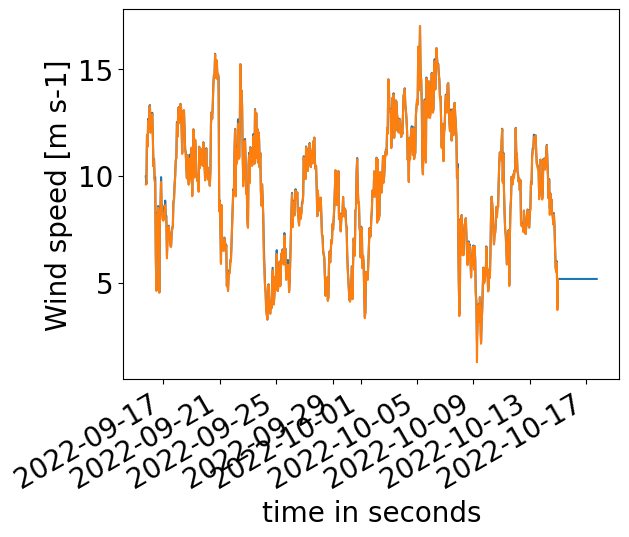

In [34]:
#dsadcpH.VWND_MEAN.plot()
#dsadcpH.UWND_MEAN.plot()
dsadcpH.WIND_SPEED_MEAN.plot()

plt.plot(dsadcpH.time, (dsadcpH.VWND_MEAN**2+dsadcpH.UWND_MEAN**2)**0.5)